<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/ADMIR_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
!pip install --upgrade nibabel
!pip install --upgrade numpy

Requirement already up-to-date: nibabel in /usr/local/lib/python3.6/dist-packages (3.2.0)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.4)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nb
import os, sys, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms



In [3]:
print("nibabel version: {}".format(nb.__version__))
print("pytorch version: {}".format(torch.__version__))
print("numpy version: {}".format(np.__version__))

nibabel version: 3.0.2
pytorch version: 1.7.0+cu101
numpy version: 1.18.5


In [4]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/"
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T2_BET_undersampled/"

# data_path_t1 = "/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/ICNet/Dataset/T1_resampled/"
# data_path_t2 = "/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/ICNet/Dataset/T2_resampled/"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))

In [5]:
print(file_names_t1[0:5] + file_names_t1[45:])
print(file_names_t2[0:5] + file_names_t2[45:])
print(len(file_names_t1))
print(len(file_names_t2))

['/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI002-Guys-0828-T1_resampled.nii.gz', '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI027-Guys-0710-T1_resampled.nii.gz', '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI028-Guys-1038-T1_resampled.nii.gz', '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI034-HH-1260-T1_resampled.nii.gz', '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI035-IOP-0873-T1_resampled.nii.gz', '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI588-IOP-1158-T1_resampled.nii.gz', '/content/drive/My Drive/Image_Registration

In [6]:
!ls -ltr

total 8
drwxr-xr-x 1 root root 4096 Nov 13 17:33 sample_data
drwx------ 5 root root 4096 Nov 25 03:40 drive


# Image Processing

In [7]:
img_nb1 = nb.load(file_names_t1[0])
print(img_nb1.shape)
img_nb2 = nb.load(file_names_t2[0])
print(img_nb2.shape)

(128, 128, 75)
(128, 128, 65)


In [8]:
def load_4D(name):
    model_np = np.zeros(shape=(128, 128, 128))
    X_nb = nb.load(name)
    X_np = X_nb.dataobj
    #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
    model_np[:, :, 0:X_np.shape[2]] = X_np[0:128, 0:128, :]
    model_np = np.reshape(model_np, (1,)+ model_np.shape)
    return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

In [9]:
myimg = load_4D(file_names_t2[0])
myimg1 = Norm_Zscore(imgnorm(myimg))
myimg2 = imgnorm(myimg)

In [ ]:
res = np.random.permutation(50)

In [ ]:
res

array([14, 45, 35,  6, 30, 49,  9, 47, 25, 33,  7, 36,  3, 15,  1, 46, 37,
       19, 44, 48, 43, 26, 31, 24, 23, 34,  4, 38, 16, 40, 32,  0, 18, 22,
       41,  5, 11,  8, 29, 20, 39, 13, 28,  2, 27, 42, 21, 12, 17, 10])

In [10]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        # Select sample
        # print(self.names)
        # print("idx: {}".format(idx))
        # index_pair = np.random.permutation(len(self.t1_filenames)) [0:4]
        img_A = load_4D(self.t1_filenames[idx])
        img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])     
        
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            return  imgnorm(img_A) , imgnorm(img_B)
        else:
            return img_A, img_B



In [11]:
training_generator = Data.DataLoader(Dataset(file_names_t1, file_names_t2,norm=True), batch_size=2, shuffle=False)

In [13]:
validation_generator = Data.DataLoader(Dataset(file_names_t1, file_names_t2,norm=True), batch_size=1, shuffle=False)

In [ ]:
for fp in file_names_t1:
  myimg = load_4D(fp)
  myimg_norm = imgnorm(myimg)
  myimg_znorm = Norm_Zscore(myimg_norm)
  print(fp)
  print("Max values of natural image, normalized and z-normalized are: {}, {} and {}".format(np.max(myimg), np.max(myimg_norm), np.max(myimg_znorm) ))
  print("Min values of natural image, normalized and z-normalized are: {}, {} and {}".format(np.min(myimg), np.min(myimg_norm), np.min(myimg_znorm) ))
  print("Mean values of natural image, normalized and z-normalized are: {}, {} and {}".format(np.mean(myimg), np.mean(myimg_norm), np.mean(myimg_znorm) ))
  print("========= ========== ======")
  print()


#print(np.max(myimg))
#print(np.min(myimg1))
#print(np.min(myimg2))

/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI002-Guys-0828-T1_resampled.nii.gz
Max values of natural image, normalized and z-normalized are: 855.2191772460938, 1.0 and 6.431156635284424
Min values of natural image, normalized and z-normalized are: 0.0, 0.0 and -0.29746782779693604
Mean values of natural image, normalized and z-normalized are: 29.659974234394213, 0.0442093089222908 and -1.3504177331924438e-07
========= ========== ======

/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Brain_extracted_Train/T1_BET_undersampled/Bet_IXI027-Guys-0710-T1_resampled.nii.gz
Max values of natural image, normalized and z-normalized are: 2687.13330078125, 1.0 and 5.290902137756348
Min values of natural image, normalized and z-normalized are: 0.0, 0.0 and -0.43514204025268555
Mean values of natural image, normalized and z-normalized are: 175.75349269299568, 0.07599348574876785 and 1.3969838619232

KeyboardInterrupt: ignored

In [ ]:
ex1 = torch.rand(2, 40, 4, 4, 4)
ex2 = ex1.flatten(start_dim=1, end_dim=4)
ex2.shape

torch.Size([2, 2560])

In [ ]:
for X,Y in training_generator:
  print(X.shape)
  print(Y.shape)
  break

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])


# Building Affine Model

In [91]:
class Admir_Affine_Encoder(nn.Module):
    def __init__(self, in_channel, start_channel, num_conv_blocks=6):
        self.in_channel = in_channel
        self.start_channel = start_channel
        self.num_conv_blocks = num_conv_blocks
        self.encoder_layer_list = []
        super(Admir_Affine_Encoder, self).__init__()
        self.create_model()

    def affine_conv_block(self, in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, bias=True ):
      layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias, ),
                            nn.BatchNorm3d(out_channels),
                            nn.LeakyReLU())
      layer.to("cuda")
      return layer
    

    def create_model(self):
      for i in range(self.num_conv_blocks):
          if(i == 0):
            lyr = self.affine_conv_block(in_channels = self.in_channel, out_channels = self.start_channel)
            lyr.to("cuda")
            self.encoder_layer_list.append(lyr)
          else:
            lyr = self.affine_conv_block(in_channels= self.start_channel * i, out_channels = self.start_channel * (i+1))
            lyr.to("cuda")
            self.encoder_layer_list.append(lyr)

    def forward(self, x, y):
      # print("x,y", x.shape, "  ", y.shape)
      x_in=torch.cat((x, y), 1)
      e0 = self.encoder_layer_list[0](x_in)

      e1 = self.encoder_layer_list[1](e0)

      if(torch.isnan(e1).any()):
        print("e1 is nan")
        print(e0)
        print()

      e2 = self.encoder_layer_list[2](e1)

      if(torch.isnan(e2).any()):
        print("e2 is nan")
        print(e1)

      e3 = self.encoder_layer_list[3](e2)

      if(torch.isnan(e3).any()):
        print("e3 is nan")
        print(e2)

      e4 = self.encoder_layer_list[4](e3)

      if(torch.isnan(e4).any()):
        print("e4 is nan")
        print(e3)

      return e4


In [ ]:
affine_conv_model = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)

In [67]:
######## To print layer outputs ########
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
                    
    def forward(self, x):
        # Do your print / debug stuff here
        if(torch.isnan(x).any()):
          print(x.shape)
          print(x)
        return x

In [92]:
class Admir_Affine_Translation_Output(nn.Module):
  def __init__(self, in_units, out_units=128, dropout_prob = 0.2):
    
    self.in_units = in_units
    self.out_units = out_units
    self.dropout_prob = dropout_prob
    super(Admir_Affine_Translation_Output, self).__init__()
    self.trns_ob = nn.Sequential(
          nn.Linear(in_features = in_units, out_features= 128),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features = 128, out_features= 3 )
          )

  def forward(self, input_tnsr):
    ip = input_tnsr.flatten(start_dim=1, end_dim=4)
    translation_output = self.trns_ob(ip)
    return translation_output

  def translation_output_block(self, in_units, out_units):
    layer = nn.Sequential(
          nn.Linear(in_features = in_units, out_features= out_units),
          PrintLayer(),
          nn.Dropout(p=self.dropout_prob),
          
          nn.Linear(in_features=out_units, out_features= out_units//2),
          #PrintLayer(),
          nn.Dropout(p=self.dropout_prob),

          nn.Linear(in_features=out_units//2, out_features= out_units//4),
          #PrintLayer(),
          nn.Dropout(p=self.dropout_prob),

          nn.Linear(in_features=out_units//4, out_features= out_units//8),
          #PrintLayer(),
          nn.Dropout(p=self.dropout_prob),

          nn.Linear(in_features=out_units//8, out_features= 3)
          #PrintLayer()
          ).to("cuda")

    return layer

In [93]:
class Admir_Affine_Shear_Output(nn.Module):
  def __init__(self, in_units, out_units=128, dropout_prob = 0.2):
    
    self.in_units = in_units
    self.out_units = out_units
    self.dropout_prob = dropout_prob
    super(Admir_Affine_Shear_Output, self).__init__()
    self.rss_ob = nn.Sequential(
          nn.Linear(in_features = in_units, out_features= 128),
          nn.Dropout(p=self.dropout_prob),
          nn.Linear(in_features = 128, out_features= 9),
          nn.Tanh())
  
  def forward(self, input_tnsr):
    ip = input_tnsr.flatten(start_dim=1, end_dim=4)
    rotate_scale_shear_output = self.rss_ob(ip)
    return rotate_scale_shear_output

In [94]:
affine_translation_output = Admir_Affine_Translation_Output( in_units= 2560).to("cuda")
affine_shear_output = Admir_Affine_Shear_Output( in_units= 2560).to("cuda")

In [95]:
counter = 0
for X,Y in training_generator:
  X = X.cuda().float()
  Y = Y.cuda().float()
  print(X.shape)
  print(Y.shape)
  conv_out = affine_conv_model(X, Y)
  print(conv_out.shape)
  translation_params = affine_translation_output(conv_out)
  rotation_shear_scale_params = affine_shear_output(conv_out)
  print(translation_params.shape)
  print(translation_params)
  print()
  print(rotation_shear_scale_params.shape)
  print(rotation_shear_scale_params)
  print("========== ============== =============")
  print()
  counter = counter + 1
  if(counter > 3):
    break;

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 40, 4, 4, 4])
torch.Size([2, 3])
tensor([[-0.1092,  0.0202, -0.2641],
        [-0.6296, -0.7273,  0.1905]], device='cuda:0', grad_fn=<AddmmBackward>)

torch.Size([2, 9])
tensor([[ 0.1710,  0.5401,  0.0863, -0.0171,  0.5131,  0.0644,  0.1105, -0.1732,
         -0.1306],
        [ 0.5550,  0.5657,  0.2592, -0.2912,  0.5870,  0.2064, -0.2683,  0.4516,
         -0.1888]], device='cuda:0', grad_fn=<TanhBackward>)
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 40, 4, 4, 4])
torch.Size([2, 3])
tensor([[ 0.0975, -0.0241,  0.3462],
        [-0.0362,  0.0106,  0.1360]], device='cuda:0', grad_fn=<AddmmBackward>)

torch.Size([2, 9])
tensor([[ 0.4131,  0.1635, -0.0263, -0.2937,  0.3759,  0.1801,  0.0300, -0.1495,
          0.2622],
        [ 0.0701,  0.3025,  0.3820, -0.2489,  0.6541,  0.0313,  0.1006, -0.1144,
          0.0204]], device='cu

# Spatial Transform

In [96]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (2, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)

    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)        
        warped_image = F.grid_sample(src, grid)
        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


In [ ]:
rotated_affine_matrix = torch.from_numpy(np.array([ [ [0.0, 0.0, -1.0, 0.0], [ 0.0, -1.0, 0.0, 0.0], [-1.0,  0.0, 0.0, 0.0] ] ], dtype="float32" ))
affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] ], dtype="float32" ))
print(affine_matrix.shape)
print(affine_matrix.dtype)

torch.Size([1, 3, 4])
torch.float32


In [ ]:
mytnsr = torch.randn(size= (1, 3, 4))
mytnsr.dtype

torch.float32

In [ ]:
spatial_transformer_affine = SpatialTransformer(size=(128, 128, 128), is_affine=True, theta=affine_matrix,  affine_image_size =  (1, 1, 128, 128, 128))
print(spatial_transformer_affine.grid.shape)
print(spatial_transformer_affine.isaffine)
print("========= =========== ======")
print()

torch.Size([1, 128, 128, 128, 3])
True
========= =========== ======



In [ ]:
counter = 0
for X, Y in validation_generator:
  print(X.dtype)
  warped_image_tensor = spatial_transformer_affine(Y)
  counter = counter + 1

  warped_image_np = warped_image_tensor.numpy()
  if(counter >= 1):
    break;


Oreintation: ('P', 'S', 'R')
Oreintation: ('L', 'A', 'S')
torch.float32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


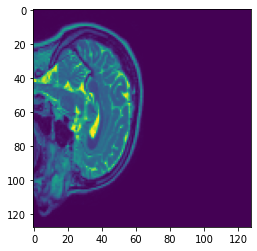

In [ ]:
plt.imshow(warped_image_np[0, 0, 64, :, :])

Oreintation: ('P', 'S', 'R')


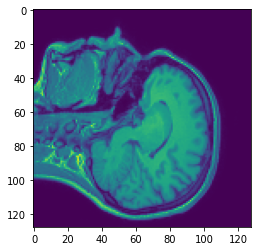

In [ ]:
mynb_np1 = load_4D(file_names_t1[0])
plt.imshow(mynb_np1[0, :, :, 32])

Oreintation: ('L', 'A', 'S')


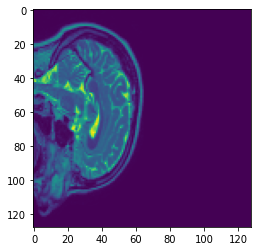

In [ ]:
mynb_np2 = load_4D(file_names_t2[0])
plt.imshow(mynb_np2[0, 64, :, :])

In [ ]:
spatial_transformer_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False)
print(spatial_transformer_deformable.grid.shape)
print(spatial_transformer_deformable.isaffine)
print("========= =========== ======")
print()

torch.Size([1, 3, 128, 128, 128])
False
========= =========== ======



In [ ]:
rot_scale_shear_tnsr = torch.randn(size=(2,9))
translate_tnsr = torch.randn(size=(2,3))
print(rot_scale_shear_tnsr)
print(translate_tnsr)

rss_rt = torch.reshape(rot_scale_shear_tnsr,(2, 3, 3))
t_rt = torch.reshape(translate_tnsr, (2, 3, 1))

print()
print("======================== ======================== =============")
print()
print(rss_rt)
print(t_rt)
print("======================== ======================== =============")
print()

tensor([[ 1.7058, -0.9189,  1.9667, -0.9155, -1.1828,  1.3028,  0.7366,  0.0579,
          0.9194],
        [ 1.1238, -0.6908, -0.3547, -1.5290,  0.0779,  0.5632, -2.7444,  0.3896,
         -1.0563]])
tensor([[-0.6032,  0.7513, -0.4750],
        [-0.3685,  0.6354, -1.3786]])

======================== ======================== =============

tensor([[[ 1.7058, -0.9189,  1.9667],
         [-0.9155, -1.1828,  1.3028],
         [ 0.7366,  0.0579,  0.9194]],

        [[ 1.1238, -0.6908, -0.3547],
         [-1.5290,  0.0779,  0.5632],
         [-2.7444,  0.3896, -1.0563]]])
tensor([[[-0.6032],
         [ 0.7513],
         [-0.4750]],

        [[-0.3685],
         [ 0.6354],
         [-1.3786]]])
======================== ======================== =============



In [ ]:
sample_cat_tnsr = torch.cat((rss_rt, t_rt), 2)
theta = torch.reshape(sample_cat_tnsr, (2, 3, 4))
theta

tensor([[[ 1.7058, -0.9189,  1.9667, -0.6032],
         [-0.9155, -1.1828,  1.3028,  0.7513],
         [ 0.7366,  0.0579,  0.9194, -0.4750]],

        [[ 1.1238, -0.6908, -0.3547, -0.3685],
         [-1.5290,  0.0779,  0.5632,  0.6354],
         [-2.7444,  0.3896, -1.0563, -1.3786]]])

In [ ]:
theta.shape

torch.Size([2, 3, 4])

# Deformable ConvNet

In [99]:
class Admir_Deformable_UNet(nn.Module):
  def __init__(self,in_channel  , n_classes,start_channel):
        self.in_channel = in_channel
        self.n_classes = n_classes
        self.start_channel = start_channel
        super(Admir_Deformable_UNet, self).__init__()
        self.eninput = self.encoder(self.in_channel, self.start_channel, bias=False)

        self.ec1 = self.encoder(self.start_channel, self.start_channel, bias=False)
        self.ec2 = self.encoder(self.start_channel, self.start_channel*2, stride=2, bias=False)

        self.ec3 = self.encoder(self.start_channel*2, self.start_channel*2, bias=False)
        self.ec4 = self.encoder(self.start_channel*2, self.start_channel*4, stride=2, bias=False)

        self.ec5 = self.encoder(self.start_channel*4, self.start_channel*4, bias=False)
        self.ec6 = self.encoder(self.start_channel*4, self.start_channel*8, stride=2, bias=False)

       
    
        self.dc1 = self.encoder(self.start_channel*8, self.start_channel*8, kernel_size=3, stride=1, bias=False) 
        self.dc2 = self.encoder(self.start_channel*4, self.start_channel*4, kernel_size=3, stride=1, bias=False)          
        self.dc3 = self.encoder(self.start_channel*2, self.start_channel*2, kernel_size=3, stride=1, bias=False)

        self.up1 = self.decoder(self.start_channel*8, self.start_channel*4)
        self.up2 = self.decoder(self.start_channel*4, self.start_channel*2)
        self.up3 = self.decoder(self.start_channel*2, self.start_channel)

        self.dc4 = self.output(self.start_channel, self.n_classes,kernel_size=1,bias=False)

  def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                bias=True):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm3d(out_channels),
                nn.LeakyReLU())
    return layer

  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=bias),
                                nn.LeakyReLU())
    return layer
       
  def output(self, in_channels, out_channels, kernel_size=3, 
                bias=False, batchnorm=False):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias),
               )
    return layer

  def forward(self, x,y):
        # print("x,y", x.shape, "  ", y.shape)
        x_in=torch.cat((x, y), 1)  
        e0 = self.eninput(x_in)

        # print("e0", e0.shape)

        e0 = self.ec1(e0)
        es1 = self.ec2(e0)   #strided
        # print("e0", e0.shape)
        # print("es1", es1.shape)

        e1 = self.ec3(es1)   
        es2 = self.ec4(e1)   #strided
        # print("e1", e1.shape)
        # print("es2", es2.shape)

        e2 = self.ec5(es2)
        es3 = self.ec6(e2)   #strided
        # print("e2", e2.shape)
        # print("es3", es3.shape)

        

        d0 = self.dc1(es3)
        # print("d0", d0.shape)

        d0 = torch.add(self.up1(d0), e2)
        # print("d0", d0.shape)

        d1 = self.dc2(d0)
        d1 = torch.add(self.up2(d1), e1)
        # print("d1", d1.shape)

        d2 = self.dc3(d1)
        d2 = torch.add(self.up3(d2), e0)
        # print("d2", d2.shape)

        output = self.dc4(d2)
        return output

In [98]:
torch.cuda.empty_cache()
model = Admir_Deformable_UNet(2,3,16).cuda() # assining cuda to model

for X,Y in training_generator:
  X = X.cuda().float()
  Y = Y.cuda().float()
  print(X.shape)
  print(Y.shape)
  out = model(X, Y)
  print(out.shape)
  print("========== ============== =============")
  print()

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
========== ============== =============


KeyboardInterrupt: ignored

# Loss Function NCC

Reference: https://github.com/yuta-hi/pytorch_similarity

In [100]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc

    return ncc, ncc_map


In [101]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

In [ ]:
#  Checking NCC loss

similarity_loss = NormalizedCrossCorrelation()
for X,Y in training_generator:
  X = X.cuda().float()
  Y = Y.cuda().float()
  print(X.shape)
  print(Y.shape)
  out = similarity_loss(X, Y)
  print(out)
  print("========== ============== =============")
  print()

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.6637, device='cuda:0')
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.7504, device='cuda:0')
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.6443, device='cuda:0')
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.6497, device='cuda:0')
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.6652, device='cuda:0')
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.6627, device='cuda:0')
========== ============== =============

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])
tensor(0.7163, device='cuda:0')
========== ============== =============

torch.Size([2

KeyboardInterrupt: ignored

# Loss Function Mutual Information 

In [ ]:
num_bins = 10
bin_centers = np.linspace(0, 0.7, num_bins*2+1)[1::2]
sigma = np.mean(np.diff(bin_centers)) * 0.5
preterm = torch.tensor(1 / (2 * np.square(sigma)))
dim_prod = 128*128*128
print(num_bins)
print(bin_centers)
print(sigma)
print(preterm)

10
[0.035 0.105 0.175 0.245 0.315 0.385 0.455 0.525 0.595 0.665]
0.034999999999999996
tensor(408.1633, dtype=torch.float64)


In [ ]:
def mutual_information(y_true, y_pred, sigma, preterm, bin_centers, nb_voxels, dim_prod=128 * 128 * 128):

  y_true = torch.reshape(y_true, (y_true.shape[0], dim_prod, 1) )
  y_pred = torch.reshape(y_pred, (y_pred.shape[0], dim_prod, 1) )

  vbc = torch.tensor(bin_centers)
  vbc = vbc.unsqueeze(0)
  vbc = vbc.unsqueeze(0)

  # compute image terms
  I_a = torch.exp(- preterm * torch.square(y_true  - vbc))
  I_a = I_a/torch.sum(I_a)

  #print(I_a)

  I_b = torch.exp(- preterm * torch.square(y_pred  - vbc))
  I_b = I_b/torch.sum(I_b)

  #print(I_b)

  # compute probabilities
  I_a_permute = I_a.permute(0,2,1)
  pab = torch.matmul(I_a_permute, I_b) 
  #print(pab)
  #print(torch.sum(pab))

  # should be the right size now, nb_labels x nb_bins
  pab = pab/nb_voxels
  pa = torch.mean(I_a, 1, keepdims=True)
  pb = torch.mean(I_b, 1, keepdims=True)

  papb = torch.matmul(pa.permute(0,2,1), pb) + torch.finfo(torch.float32).eps
  #print(papb)

  mi = torch.sum(torch.sum(pab * torch.log(pab/papb + torch.finfo(torch.float32).eps), 1), 1)

  return -mi


In [ ]:
class NormalizedMutualInformation(nn.Module):

    def __init__(self,
                 dim_prod = 128*128*128,
                 num_bins = 10,
                 bin_centers = np.linspace(0, 0.7, 10*2+1)[1::2],
                 sigma = np.mean(np.diff(bin_centers)) * 0.5,
                 preterm = torch.tensor(1 / (2 * np.square(sigma))),
                 nb_voxels = torch.tensor([dim_prod], dtype=torch.float32)
                 ):

        super(NormalizedMutualInformation, self).__init__()

        self.dim_prod = dim_prod
        self.num_bins = num_bins
        self.bin_centers = bin_centers
        self.sigma = sigma
        self.preterm = preterm
        self.nb_voxels = nb_voxels

    def forward(self, x, y):

        return mutual_information(x,y, self.sigma, self.preterm, self.bin_centers, self.nb_voxels, self.dim_prod)

In [ ]:
nmi_loss = NormalizedMutualInformation()
counter = 0
for X,Y in training_generator:

  print(nmi_loss(X, X))
  counter = counter + 1
  if(counter > 2):
    break;

tensor([2.7666e-11, 2.9524e-11], dtype=torch.float64)
tensor([2.7642e-11, 1.9366e-11], dtype=torch.float64)
tensor([2.3615e-11, 1.0710e-11], dtype=torch.float64)


# Regularizer - DVF edge smoothness

In [123]:
def smoothness_regularizer( input_tensor=None):
  if(input_tensor == None):
    dvf_tensor = torch.randn(size=(4, 3, 128, 128, 128)).cuda()
  else:
    dvf_tensor = input_tensor
  
  dvf_x = dvf_tensor[:, 0:1, ...]
  dvf_y = dvf_tensor[:, 1:2, ...]
  dvf_z = dvf_tensor[:, 2:3, ...]

  sobel_z = torch.FloatTensor( [ [ [ [ [1,2,1], [2,4,2], [1,2,1] ], [ [0,0,0], [0,0,0], [0,0,0] ], [ [-1,-2,-1], [-2,-4,-2], [-1,-2,-1] ] ] ] ] ).cuda()
  sobel_y = torch.FloatTensor( [ [ [ [ [1,2,1], [0,0,0], [-1,-2,-1] ], [ [2,4,2], [0,0,0], [-2,-4,-2] ], [ [1,2,1], [0,0,0], [-1,-2,-1] ] ] ] ] ).cuda()
  sobel_x = torch.FloatTensor( [ [ [ [ [1,0,-1], [2,0,-2], [1,0,-1] ], [ [2,0,-2], [4,0,-4], [2,0,-2] ], [ [1,0,-1], [2,0,-2], [1,0,-1] ] ] ] ] ).cuda()

  edges_x = F.conv3d(input=dvf_x, weight=sobel_x , stride=1, padding=1)
  edges_y = F.conv3d(input=dvf_y, weight=sobel_y , stride=1, padding=1)
  edges_z = F.conv3d(input=dvf_z, weight=sobel_z , stride=1, padding=1)

  magnitude_of_edges_along_x = torch.norm(edges_x)
  magnitude_of_edges_along_y = torch.norm(edges_y)
  magnitude_of_edges_along_z = torch.norm(edges_z)
  #print("Magnitudes of gradients along x, y and z are {}, {} and {}".format(magnitude_of_edges_along_x, magnitude_of_edges_along_y, magnitude_of_edges_along_z))

  return magnitude_of_edges_along_x + magnitude_of_edges_along_y + magnitude_of_edges_along_z

#print(smoothness_regularizer())


In [124]:
class Smoothnessloss(nn.Module):
    def __init__(self):

        super(Smoothnessloss, self).__init__()
        
    def forward(self, x):
        smth_loss = smoothness_regularizer( x)
        return torch.sqrt(smth_loss)

In [104]:
sl = Smoothnessloss()
sl(torch.randn(size=(2,3,128,128,128)).cuda())

tensor(227.5279, device='cuda:0')

In [105]:
dvf_tensor = torch.randn(size=(4, 3, 128, 128, 128))

dvf_x = dvf_tensor[:, 0:1, ...]
dvf_y = dvf_tensor[:, 1:2, ...]
dvf_z = dvf_tensor[:, 2:3, ...]
print(dvf_z.shape)

torch.Size([4, 1, 128, 128, 128])


In [106]:
sobel_z = torch.FloatTensor( [ [ [ [ [1,2,1], [2,4,2], [1,2,1] ], [ [0,0,0], [0,0,0], [0,0,0] ], [ [-1,-2,-1], [-2,-4,-2], [-1,-2,-1] ] ] ] ] )
sobel_y = torch.FloatTensor( [ [ [ [ [1,2,1], [0,0,0], [-1,-2,-1] ], [ [2,4,2], [0,0,0], [-2,-4,-2] ], [ [1,2,1], [0,0,0], [-1,-2,-1] ] ] ] ] )
sobel_x = torch.FloatTensor( [ [ [ [ [1,0,-1], [2,0,-2], [1,0,-1] ], [ [2,0,-2], [4,0,-4], [2,0,-2] ], [ [1,0,-1], [2,0,-2], [1,0,-1] ] ] ] ] )
print(sobel_x.shape)

torch.Size([1, 1, 3, 3, 3])


In [107]:
edges_x = F.conv3d(input=dvf_x, weight=sobel_x , stride=1, padding=1)
edges_y = F.conv3d(input=dvf_y, weight=sobel_y , stride=1, padding=1)
edges_z = F.conv3d(input=dvf_z, weight=sobel_z , stride=1, padding=1)

In [ ]:
edges_y.shape

torch.Size([4, 1, 128, 128, 128])

In [108]:
magnitude_of_edges_along_x = torch.norm(edges_x)
magnitude_of_edges_along_y = torch.norm(edges_y)
magnitude_of_edges_along_z = torch.norm(edges_z)
print("Magnitudes of gradients along x, y and z are {}, {} and {}".format(magnitude_of_edges_along_x, magnitude_of_edges_along_y, magnitude_of_edges_along_z))

Magnitudes of gradients along x, y and z are 24270.021484375, 24266.30078125 and 24249.443359375


In [ ]:
sobel_np_z

array([[[ 1.,  2.,  1.],
        [ 2.,  4.,  2.],
        [ 1.,  2.,  1.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[-1., -2., -1.],
        [-2., -4., -2.],
        [-1., -2., -1.]]], dtype=float32)

In [ ]:
sobel_np_y

array([[[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]],

       [[ 2.,  4.,  2.],
        [ 0.,  0.,  0.],
        [-2., -4., -2.]],

       [[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]]], dtype=float32)

In [ ]:
sobel_np_x

array([[[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]],

       [[ 2.,  0., -2.],
        [ 4.,  0., -4.],
        [ 2.,  0., -2.]],

       [[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]]], dtype=float32)

# Aggregation Affine DVF and Deformable DVF 


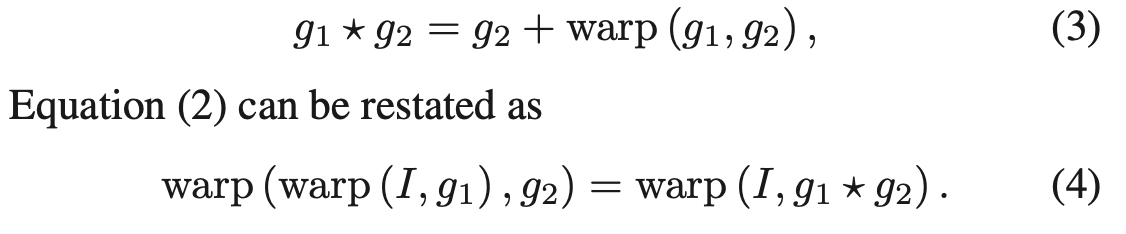





**Steps:**
 According to eq. 3, warp DVF of affine(g1) with DVF of deformable(g2), and then add the result to DVF of deformable(g2).


In [ ]:
affine_conv_model = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)
affine_output_model = Admir_Affine_Output( in_units= 2560)
stn_affine = SpatialTransformer(size=(128, 28, 128), is_affine=True, theta=torch.randn(size=(2, 3, 4)))

deformable_model = Admir_Deformable_UNet(2,3,16)

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_aggregation = SpatialTransformer(size=(128, 128, 128), is_affine=False)

stn_fully_warped = SpatialTransformer(size=(128, 128, 128), is_affine=False)



In [ ]:
stn_affine.grid.shape

torch.Size([2, 128, 128, 128, 3])

In [ ]:
final_warped_image = stn_deformable(torch.randn(size=(2,3,128,128,128)), torch.randn(size=(2,3,128,128,128)) )

In [ ]:
final_warped_image.shape

torch.Size([2, 3, 128, 128, 128])

In [ ]:
batch_size = 2


# X --> fixed and Y --> moving

for X,Y in training_generator:

  # X = X.cuda().float()
  # Y = Y.cuda().float()

  print("X shape: {}".format(X.shape))
  print("Y shape: {}".format(Y.shape))
  affine_conv_out = affine_conv_model(X, Y)
  # print(affine_conv_out.shape)

  affine_output_out = affine_output_model(affine_conv_out)
  print(affine_output_out[0].shape)
  print(affine_output_out[1].shape)

  print("========== ============== =============")
  print()

  affine_tnsr = torch.cat((affine_output_out[1], affine_output_out[0]), 1)
  theta = torch.reshape(affine_tnsr, (batch_size, 3, 4))

  
  # Suraj: Set the new theta and reshape it
  stn_affine.theta = theta
  print("========== ============== =============")
  print("theta shape: {}".format(theta.shape))
  print(theta)

  # print("========== ============== =============")
  # grid = F.affine_grid(theta, (2, 1, 128, 128, 128))
  # print(grid.shape)
  # print(grid)

  # Suraj: Added coarsely warped image, changed dvf_final calculation
  # DVF1 shape was [batch size, 128, 128, 128, 3] --> permuted order of columns to match deformable dvf 2 [batch size, 3, 128, 128, 128]
  coarsely_warped_image = stn_affine(Y)
  dvf_1 = stn_affine.grid
  dvf_1 = dvf_1.permute(0, 4, 1, 2, 3)

  print("======= =============== ===========")
  print("Coarsely warped image shape: {}".format(coarsely_warped_image.shape))
  print("dvf 1 shape: {}".format(dvf_1.shape))
  print("=========== ============= ==========")
  print()

  print(" ==== Starting deformable warping =======")
  dvf_2 = deformable_model(coarsely_warped_image, Y) 
  print("deformable field dvf 2 shape: {}".format(dvf_2.shape))
  print("========== ============== =============")
  print()

  print(" interim warp ")
  interim_warp_field = stn_aggregation(dvf_1,dvf_2)
  print("interim warp field shape: {}".format(interim_warp_field.shape))
  print("========== ============== =============")
  print()

  
  dvf_final = dvf_2 + interim_warp_field
  print("final dvf shape: {}".format(dvf_final.shape))
  print("========== ============== =============")
  print()

  fully_warped_image =  stn_fully_warped(Y,dvf_final)  #final fully warped image , i.e. equation 4 of the image
  print("final warped image shape: {}".format(fully_warped_image.shape))
  print("========== ============== =============")
  print()
  

  del X
  del Y
  del interim_warp_field
  del dvf_1
  del dvf_2
  del dvf_final
  del fully_warped_image

  """
  # something is missing here may be: TBD

  dvf_1 = F.grid_sample(Y, grid)    #named as g1 in the image
  print(dvf_1.shape)
  print("========== ============== =============")
  print()
  
  dvf_2 = deformable_model(dvf_1, Y)     #named as g2 in the image
  print(dvf_2.shape)
  print("========== ============== =============")
  print()
  
  dvf_final = dvf_2 + stn_aggregation(dvf_1,dvf_2)    # g1 * g2,  aggregation of DVF (Affine) and DVF (Deformable)
  print(dvf_final.shape)
  print("========== ============== =============")
  print()

  fully_warped_image =  stn_fully_warped(Y,dvf_final)  #final fully warped image , i.e. equation 4 of the image
  print(fully_warped_image.shape)
  print("========== ============== =============")
  print()
  """
  

X shape: torch.Size([2, 1, 128, 128, 128])
Y shape: torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

========== ============== =============
theta shape: torch.Size([2, 3, 4])
tensor([[[-0.1161, -0.2802, -0.3322, -0.1159],
         [-0.1681, -0.4785,  0.0086, -0.1808],
         [-0.1069,  0.1317, -0.0420,  0.2455]],

        [[ 0.0276, -0.2756, -0.2953,  0.0351],
         [-0.0728, -0.1741, -0.1754, -0.0482],
         [-0.2195,  0.2257,  0.0267,  0.4620]]], grad_fn=<ViewBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


======= =============== ===========
Coarsely warped image shape: torch.Size([2, 1, 128, 128, 128])
dvf 1 shape: torch.Size([2, 3, 128, 128, 128])
=========== ============= ==========

 ==== Starting deformable warping =======
d2 torch.Size([2, 16, 128, 128, 128])
deformable field dvf 2 shape: torch.Size([2, 3, 128, 128, 128])
========== ============== =============

 interim warp 
interim warp field shape: torch.Size([2, 3, 128, 128, 128])
========== ============== =============

final dvf shape: torch.Size([2, 3, 128, 128, 128])
========== ============== =============

final warped image shape: torch.Size([2, 1, 128, 128, 128])
========== ============== =============

X shape: torch.Size([2, 1, 128, 128, 128])
Y shape: torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 3])
torch.Size([2, 9])
========== ============== =============

========== ============== =============
theta shape: torch.Size([2, 3, 4])
tensor([[[-0.1642, -0.2519, -0.2274, -0.0296],
         [-0.0043, -0.4660,  0.0361

# Training Affine Network to sanity check

In [ ]:
affine_conv_model = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)
affine_conv_model.cuda()

affine_output_model = Admir_Affine_Output( in_units= 2560)
affine_output_model.cuda()


affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] , 
                                            [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ]  ], dtype="float32" )).cuda()
stn_affine = SpatialTransformer(size=(128, 28, 128), is_affine=True, theta=affine_matrix)
stn_affine.cuda()

# Addd deformable part
deformable_model = Admir_Deformable_UNet(2,3,16)
deformable_model.cuda()

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_deformable.cuda()

stn_aggregation = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_aggregation.cuda()

stn_fully_warped = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_fully_warped.cuda()


lr=2e-4
iteration=2
alpha = beta = gamma = 1.0

for param in stn_affine.parameters():
  param.requires_grad = False
  param.volatile=True

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True

for param in stn_aggregation.parameters():
  param.requires_grad = False
  param.volatile=True

for param in stn_fully_warped.parameters():
  param.requires_grad = False
  param.volatile=True

affine_matrix

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]], device='cuda:0')

In [ ]:
similarity_loss = NormalizedCrossCorrelation()
smooth_loss = Smoothnessloss()

In [ ]:
optimizer = torch.optim.Adam( list( affine_conv_model.parameters()) + list( affine_output_model.parameters() ) , lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/Model'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

n_checkpoint=4000
lossall = np.zeros((5,iteration))
step=0

In [ ]:
batch_size = 2

# X --> fixed and Y --> moving
def affine_one_epoch_run(epoch=1):
  for X,Y in training_generator:

    X = X.cuda().float()
    Y = Y.cuda().float()

    #print("X shape: {}".format(X.shape))
    #print("Y shape: {}".format(Y.shape))
    affine_conv_out = affine_conv_model(X, Y)
    # print(affine_conv_out.shape)

    affine_output_out = affine_output_model(affine_conv_out)
    #print(affine_output_out[0].shape)
    #print(affine_output_out[1].shape)

    #print("========== ============== =============")
    #print()

    rss_rt = torch.reshape(affine_output_out[1],(batch_size, 3, 3))
    t_rt = torch.reshape(affine_output_out[0], (batch_size, 3, 1))

    theta = torch.cat((rss_rt, t_rt), 2)
    #print(theta)
    #print("========== ============== =============")
    #print()
    # theta = affine_matrix - theta
    #print(theta)
    
    # Suraj: Set the new theta and reshape it
    stn_affine.theta = theta
    #print("========== ============== =============")
    #print("theta shape: {}".format(theta.shape))
    #print(theta)

    # print("========== ============== =============")
    # grid = F.affine_grid(theta, (2, 1, 128, 128, 128))
    # print(grid.shape)
    # print(grid)

    # Suraj: Added coarsely warped image, changed dvf_final calculation
    # DVF1 shape was [batch size, 128, 128, 128, 3] --> permuted order of columns to match deformable dvf 2 [batch size, 3, 128, 128, 128]
    coarsely_warped_image = stn_affine(Y)
    dvf_1 = stn_affine.grid
    dvf_1 = dvf_1.permute(0, 4, 1, 2, 3)

    #print("======= =============== ===========")
    #print("Coarsely warped image shape: {}".format(coarsely_warped_image.shape))
    #print("dvf 1 shape: {}".format(dvf_1.shape))
    #print("=========== ============= ==========")
    #print()

    affine_loss = similarity_loss(X, coarsely_warped_image) 
    optimizer.zero_grad()          
    affine_loss.backward()           
    optimizer.step() 

    torch.cuda.empty_cache()

    del X
    del Y
    del coarsely_warped_image
    del dvf_1
  



  modelname = model_dir + '/' + "affine_admir_" + str(epoch) + '.pth'
  torch.save({"affine_conv_model": affine_conv_model.state_dict(), "affine_output_model": affine_output_model.state_dict()}, modelname)
  print("epoch: {}".format(epoch))
  print("Loss: {}".format(affine_loss))
  print("theta: {}".format(stn_affine.theta))
  print("Saving model checkpoints")
  print("======= =============== ===========")
  print()


In [ ]:
epochs = 10
for e in range(epochs):
  affine_one_epoch_run(epoch=e)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


epoch: 0
Loss: -0.4200248122215271
theta: tensor([[[-0.6542, -0.3046,  0.3488,  0.0537],
         [-0.4135, -0.0659, -0.1821,  0.1665],
         [ 0.1889,  0.0597, -0.0666,  0.1384]],

        [[-0.6478, -0.1031,  0.1133, -0.0689],
         [-0.0055, -0.1802,  0.0640,  0.3196],
         [ 0.4584, -0.0438,  0.0383, -0.0285]]], device='cuda:0',
       grad_fn=<CatBackward>)
Saving model checkpoints
======= =============== ===========

epoch: 1
Loss: -0.4120467007160187
theta: tensor([[[-0.7907,  0.1419, -0.0597,  0.3014],
         [-0.0264,  0.1567,  0.0750,  0.2346],
         [ 0.4459,  0.1252,  0.0024, -0.0526]],

        [[-0.5073, -0.0573,  0.0714,  0.0448],
         [-0.1503,  0.0808,  0.1617,  0.2351],
         [ 0.4852, -0.2381,  0.0278, -0.0673]]], device='cuda:0',
       grad_fn=<CatBackward>)
Saving model checkpoints
======= =============== ===========

epoch: 2
Loss: -0.44794273376464844
theta: tensor([[[-0.7846,  0.0715, -0.0519,  0.0396],
         [-0.2477, -0.0381,  0.2357,

# Affine Inference

In [ ]:
affine_conv_model_inference = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)
affine_conv_model_inference.cuda()

affine_output_model_inference = Admir_Affine_Output( in_units= 2560)
affine_output_model_inference.cuda()

stn_affine_inference = SpatialTransformer(size=(128, 28, 128), is_affine=True, theta=torch.randn(size=(1, 3, 4)), affine_image_size =  (1, 1, 128, 128, 128))
stn_affine_inference.cuda()

SpatialTransformer()

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/fullmodel2/complete_admir_9.pth')
affine_conv_model_inference.load_state_dict(checkpoint['affine_conv_model'])
affine_output_model_inference.load_state_dict(checkpoint['affine_output_model'])
affine_conv_model_inference.eval()
affine_output_model_inference.eval()
affine_matrix_inference = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ]  ], dtype="float32" )).cuda()

In [ ]:
counter=0

In [ ]:
batch_size=1
def inference_loop(epoch=1, batch_size=1, counter=0):
  for X,Y in validation_generator:

    X = X.cuda().float()
    Y = Y.cuda().float()

    #print("X shape: {}".format(X.shape))
    #print("Y shape: {}".format(Y.shape))
    affine_conv_out = affine_conv_model_inference(X, Y)
    # print(affine_conv_out.shape)

    affine_output_out = affine_output_model_inference(affine_conv_out)
    #print(affine_output_out[0].shape)
    #print(affine_output_out[1].shape)

    #print("========== ============== =============")
    #print()

    rss_rt = torch.reshape(affine_output_out[1],(batch_size, 3, 3))
    t_rt = torch.reshape(affine_output_out[0], (batch_size, 3, 1))

    theta = torch.cat((rss_rt, t_rt), 2)


    theta = affine_matrix_inference - theta
    
    # Suraj: Set the new theta and reshape it
    stn_affine_inference.theta = theta
    #print("========== ============== =============")
    #print("theta shape: {}".format(theta.shape))
    print(theta)

    # print("========== ============== =============")
    # grid = F.affine_grid(theta, (2, 1, 128, 128, 128))
    # print(grid.shape)
    # print(grid)

    # Suraj: Added coarsely warped image, changed dvf_final calculation
    # DVF1 shape was [batch size, 128, 128, 128, 3] --> permuted order of columns to match deformable dvf 2 [batch size, 3, 128, 128, 128]
    coarsely_warped_image = stn_affine_inference(Y)
    dvf_1 = stn_affine_inference.grid
    dvf_1 = dvf_1.permute(0, 4, 1, 2, 3)

    output_warped_tensor = coarsely_warped_image.detach().to("cpu")
    #dvf_1_warped_tensor = dvf_1.detach().to("cpu")
    output_warped_np = output_warped_tensor.numpy()
    #dvf_1_warped_np = dvf_1_warped_tensor.numpy()

    output_warped_nb = nb.Nifti1Image(output_warped_np[0,0,:,:,:], np.eye(4)) 
    nb.save(output_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/' +  'output_warped_nb_' + str(counter) + '.nii.gz')
    #dvf_1_warped_nb = nb.Nifti1Image(dvf_1_warped_np[0,:,:,:,:], np.eye(4)) 
    #nb.save(dvf_1_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/' +  'dvf_1_warped_nb_' + str(counter) + '.nii.gz')

    counter = counter + 1

    if(counter > 2):
      break;

    del output_warped_tensor
    del dvf_1
    #del dvf_1_warped_tensor
    del coarsely_warped_image

In [ ]:
inference_loop()

tensor([[[ 1.2532,  0.2568, -0.2302,  0.2678],
         [-0.0149,  0.7441, -0.0894, -0.0676],
         [ 0.0034, -0.1332,  0.6160,  0.1580]]], device='cuda:0',
       grad_fn=<SubBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


tensor([[[ 1.1718,  0.2757, -0.1542,  0.2490],
         [-0.0396,  0.7898, -0.0478, -0.0742],
         [-0.0026, -0.1084,  0.5575,  0.0586]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 1.1813,  0.2354, -0.2025,  0.2821],
         [-0.0042,  0.7752, -0.0702, -0.0062],
         [ 0.0091, -0.1409,  0.6115,  0.0941]]], device='cuda:0',
       grad_fn=<SubBackward0>)


In [ ]:
warped_img = nb.load("/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/output_warped_nb_1.nii.gz")
warped_img_np = warped_img.dataobj
mynb_np1 = load_4D(file_names_t1[1])
mynb_np2 = load_4D(file_names_t1[5])

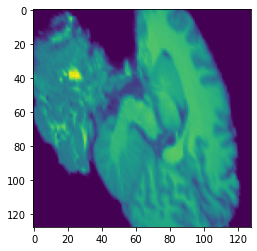

In [ ]:
plt.imshow(warped_img_np[:, :, 25])

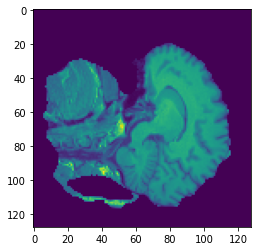

In [ ]:
plt.imshow(mynb_np1[0, :, :, 32])

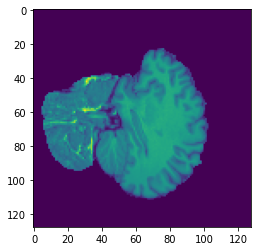

In [ ]:
plt.imshow(mynb_np2[0, :, :, 25])

# Training Full model

In [ ]:
boltn = torch.isnan(torch.from_numpy(np.array([[1.0, 0.2, np.nan], [1.0, 0.2, -0.4]]))).any()
if(boltn):
  print("true")
else:
  print("false")

true


In [133]:
affine_conv_model = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)
affine_conv_model.cuda()

#affine_output_model = Admir_Affine_Output( in_units= 2560)
#affine_output_model.cuda()

affine_translation_model = Admir_Affine_Translation_Output( in_units= 2560).to("cuda")
affine_shear_model = Admir_Affine_Shear_Output( in_units= 2560).to("cuda")

affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] , 
                                            [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ]  ], dtype="float32" )).cuda()


affine_matrix_inference = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ]  ], dtype="float32" )).cuda()


stn_affine = SpatialTransformer(size=(128, 28, 128), is_affine=True, theta=affine_matrix_inference,  affine_image_size =  (1, 1, 128, 128, 128))
stn_affine.cuda()

# Addd deformable part
deformable_model = Admir_Deformable_UNet(2,3,16)
deformable_model.cuda()

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_deformable.cuda()

stn_aggregation = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_aggregation.cuda()

stn_fully_warped = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_fully_warped.cuda()

for param in stn_affine.parameters():
  param.requires_grad = False
  param.volatile=True

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True

for param in stn_aggregation.parameters():
  param.requires_grad = False
  param.volatile=True

for param in stn_fully_warped.parameters():
  param.requires_grad = False
  param.volatile=True

In [126]:
affine_matrix

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]], device='cuda:0')

In [134]:
lr=1e-4
iteration=2
alpha = 1.0
beta = 1.0
gamma = 1.0

In [135]:
similarity_loss = NormalizedCrossCorrelation()
smooth_loss = Smoothnessloss()

In [136]:
optimizer = torch.optim.Adam( list( affine_conv_model.parameters()) + list( affine_translation_model.parameters() ) + 
                             list( affine_shear_model.parameters()) + list(deformable_model.parameters() ), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/fullmodel2'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

n_checkpoint=4000
lossall = np.zeros((5,iteration))
step=0

In [137]:
batch_size = 1

# X --> fixed and Y --> moving
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  for X,Y in validation_generator:

    X = X.cuda().float()
    Y = Y.cuda().float()

    #print("X shape: {}".format(X.shape))
    #print("Y shape: {}".format(Y.shape))
    affine_conv_out = affine_conv_model(X, Y)
    # print(affine_conv_out.shape)

    bool_conv_out = torch.isnan(affine_conv_out).any()

    if(bool_conv_out):
      print("Affine conv output is NaN")
      

    translation_out = affine_translation_model(affine_conv_out)
    rss_out = affine_shear_model(affine_conv_out)

    
    

    #print(affine_output_out[0].shape)
    #print(affine_output_out[1].shape)

    #print("========== ============== =============")
    #print()

    rss_rt = torch.reshape(rss_out,(batch_size, 3, 3))
    t_rt = torch.reshape(translation_out, (batch_size, 3, 1))

    theta = torch.cat((rss_rt, t_rt), 2)

    bool_affine_out = torch.isnan(theta).any()

    if(bool_affine_out):
      print("Affine matrix output is NaN")
      print("Mean: {}".format(torch.mean(affine_conv_out)))
      print("Min: {}".format(torch.min(affine_conv_out)))
      print("Max: {}".format(torch.max(affine_conv_out)))      
      print(theta)
      
      #del X
      #del Y
      #break;
    else:
      ;
      #print("====================     =============")
      #print("Mean: {}".format(torch.mean(affine_conv_out)))
      #print("Min: {}".format(torch.min(affine_conv_out)))
      #print("Max: {}".format(torch.max(affine_conv_out)))

    #theta = torch.reshape(affine_tnsr, (batch_size, 3, 4))


    #theta = affine_matrix - theta
    
    # Suraj: Set the new theta and reshape it
    stn_affine.theta = theta
    # print("========== ============== =============")
    #print("theta shape: {}".format(theta.shape))
    # print(theta)

    # print("========== ============== =============")
    # grid = F.affine_grid(theta, (2, 1, 128, 128, 128))
    # print(grid.shape)
    # print(grid)

    # Suraj: Added coarsely warped image, changed dvf_final calculation
    # DVF1 shape was [batch size, 128, 128, 128, 3] --> permuted order of columns to match deformable dvf 2 [batch size, 3, 128, 128, 128]
    coarsely_warped_image = stn_affine(Y)
    dvf_1 = stn_affine.grid
    dvf_1 = dvf_1.permute(0, 4, 1, 2, 3)

    #print("======= =============== ===========")
    #print("Coarsely warped image shape: {}".format(coarsely_warped_image.shape))
    #print("dvf 1 shape: {}".format(dvf_1.shape))
    #print("=========== ============= ==========")
    #print()

    affine_loss = similarity_loss(X, coarsely_warped_image) 
    # optimizer.zero_grad()           # clear gradients for this training step
    # affine_loss.backward()                 # backpropagation, compute gradients
    # optimizer.step() 

    

    # -----------------------Deformable part-----------------------

    # print(" ==== Starting deformable warping =======")
    dvf_2 = deformable_model(X, coarsely_warped_image) 
    # print("deformable field dvf 2 shape: {}".format(dvf_2.shape))
    # print("========== ============== =============")
    # print()

    # print(" interim warp ")
    interim_warp_field = stn_aggregation(dvf_1,dvf_2)
    # print("interim warp field shape: {}".format(interim_warp_field.shape))
    # print("========== ============== =============")
    # print()

  
    dvf_final = dvf_2 + interim_warp_field
    # print("final dvf shape: {}".format(dvf_final.shape))
    # print("========== ============== =============")
    # print()

    fully_warped_image =  stn_fully_warped(Y,dvf_final)  #final fully warped image , i.e. equation 4 of the image
    # print("final warped image shape: {}".format(fully_warped_image.shape))
    # print("========== ============== =============")
    # print()

    deformable_loss = similarity_loss(X, fully_warped_image) 
    # optimizer.zero_grad()                      
    # deformable_loss.backward()               
    # optimizer.step() 
     
    smooth_loss = smoothness_regularizer(dvf_2)

    total_loss = (- alpha * affine_loss )+ ( - beta * deformable_loss ) + ( gamma * smooth_loss )
    
    optimizer.zero_grad()          
    total_loss.backward() 

     
    print("=======  loss gradients for example {} ===========".format(example_number))
    translation_wght_1 = affine_translation_model.trns_ob[0].weight
    translation_wght_2 = affine_translation_model.trns_ob[2].weight
    deformable_encoder_wght_1 = deformable_model.ec1[0].weight
    print("Affine Loss, Deformable Loss and smooth loss are {}, {} and {}".format(affine_loss, deformable_loss, smooth_loss))
    translation_grad_1 = affine_translation_model.trns_ob[0].weight.grad
    translation_grad_2 = affine_translation_model.trns_ob[2].weight.grad
    deformable_encoder_grad_1 = deformable_model.ec1[0].weight.grad

    print("Min, Mean, Max and shape of gradient 1 is {}, {}, {} and {}".format(torch.min(translation_grad_1), torch.mean(translation_grad_1), torch.max(translation_grad_1), translation_grad_1.shape ))
    print("Min, Mean, Max and shape of gradient 2 is {}, {}, {} and {}".format(torch.min(translation_grad_2), torch.mean(translation_grad_2), torch.max(translation_grad_2), translation_grad_2.shape ))
    print("Min, Mean, Max and shape of gradient 3 is {}, {}, {} and {}".format(torch.min(deformable_encoder_grad_1), torch.mean(deformable_encoder_grad_1), torch.max(deformable_encoder_grad_1), deformable_encoder_grad_1.shape ))
    
    print("Min, Mean, Max and shape of weight 1 is {}, {}, {} and {}".format(torch.min(translation_wght_1), torch.mean(translation_wght_1), torch.max(translation_wght_1), translation_wght_1.shape ))
    print("Min, Mean, Max and shape of weight 2 is {}, {}, {} and {}".format(torch.min(translation_wght_2), torch.mean(translation_wght_2), torch.max(translation_wght_2), translation_wght_2.shape ))    
    print("Min, Mean, Max and shape of weight 3 is {}, {}, {} and {}".format(torch.min(deformable_encoder_wght_1), torch.mean(deformable_encoder_wght_1), torch.max(deformable_encoder_wght_1), deformable_encoder_wght_1.shape ))

    optimizer.step() 

    del X
    del Y
    del coarsely_warped_image
    del dvf_1
    del dvf_2
    del dvf_final
    del fully_warped_image

    example_number = example_number + 1



  modelname = model_dir + '/' + "complete_admir_" + str(epoch) + '.pth'
  torch.save({"affine_conv_model": affine_conv_model.state_dict(), "affine_shear_model": affine_shear_model.state_dict(),
              "affine_translation_model": affine_translation_model.state_dict(), "deformable_model": deformable_model.state_dict()}, modelname)
  print("epoch: {}".format(epoch))
  print("Losses: {}, {} and {}".format(affine_loss, deformable_loss, smooth_loss))
  print("Affine transform matrix: {}".format(stn_affine.theta))
  print("Saving model checkpoints")
  print("======= =============== ===========")
  print()

In [138]:
epochs = 10
for e in range(epochs):
  fullmodel_one_epoch_run(epoch=e)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


=======  loss gradients for example 0 ===========
Affine Loss, Deformable Loss and smooth loss are -0.04302246868610382, 0.8141061067581177 and 13037.03125
Min, Mean, Max and shape of gradient 1 is -16423.1484375, -28.812253952026367, 14709.8564453125 and torch.Size([128, 2560])
Min, Mean, Max and shape of gradient 2 is -37364.7734375, -131.02708435058594, 21775.244140625 and torch.Size([3, 128])
Min, Mean, Max and shape of gradient 3 is -4407.6845703125, 207.61923217773438, 6848.42138671875 and torch.Size([16, 16, 3, 3, 3])
Min, Mean, Max and shape of weight 1 is -0.019764183089137077, -3.3637519663898274e-05, 0.019764075055718422 and torch.Size([128, 2560])
Min, Mean, Max and shape of weight 2 is -0.08771517872810364, -0.001272979541681707, 0.08780044317245483 and torch.Size([3, 128])
Min, Mean, Max and shape of weight 3 is -0.04809308424592018, -0.00017365350504405797, 0.0481090173125267 and torch.Size([16, 16, 3, 3, 3])
=======  loss gradients for example 1 ===========
Affine Loss,

KeyboardInterrupt: ignored

# Infering Full Model

In [ ]:
affine_conv_model_inference = Admir_Affine_Encoder(in_channel=2, start_channel=8, num_conv_blocks=5)
affine_conv_model_inference.cuda()

#affine_output_model_inference = Admir_Affine_Output( in_units= 2560)
#affine_output_model_inference.cuda()

affine_translation_output_inference = Admir_Affine_Translation_Output( in_units= 2560).to("cuda")
affine_shear_output_inference = Admir_Affine_Shear_Output( in_units= 2560).to("cuda")


affine_matrix_inference = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ]  ], dtype="float32" )).cuda()
stn_affine_inference = SpatialTransformer(size=(128, 28, 128), is_affine=True, theta=torch.randn(size=(1, 3, 4)), affine_image_size =  (1, 1, 128, 128, 128))
stn_affine_inference.cuda()

# Addd deformable part
deformable_model_inference = Admir_Deformable_UNet(2,3,16)
deformable_model_inference.cuda()

stn_deformable_inference = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_deformable_inference.cuda()

stn_aggregation_inference = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_aggregation_inference.cuda()

stn_fully_warped_inference = SpatialTransformer(size=(128, 128, 128), is_affine=False)
stn_fully_warped_inference.cuda()

SpatialTransformer()

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/fullmodel2/complete_admir_9.pth')
affine_conv_model_inference.load_state_dict(checkpoint['affine_conv_model'])
affine_output_model_inference.load_state_dict(checkpoint['affine_output_model'])
deformable_model_inference.load_state_dict(checkpoint['deformable_model'])
affine_conv_model_inference.eval()
affine_output_model_inference.eval()
deformable_model_inference.eval()

Admir_Deformable_UNet(
  (eninput): Sequential(
    (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (ec1): Sequential(
    (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (ec2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (ec3): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(ne

In [ ]:
counter = 0

In [ ]:
def fullmodel_inference_loop(epoch=1, batch_size=1, counter=0):
  for X,Y in validation_generator:

    X = X.cuda().float()
    Y = Y.cuda().float()

    #print("X shape: {}".format(X.shape))
    #print("Y shape: {}".format(Y.shape))
    affine_conv_out = affine_conv_model_inference(X, Y)
    # print(affine_conv_out.shape)

    translation_out = affine_translation_output_inference(affine_conv_out)
    rss_out = affine_shear_output_inference(affine_conv_out)

    #print("========== ============== =============")
    #print()

    rss_rt = torch.reshape(rss_out,(batch_size, 3, 3))
    t_rt = torch.reshape(translation_out, (batch_size, 3, 1))

    theta = torch.cat((rss_rt, t_rt), 2)

    #affine_tnsr = torch.cat((affine_output_out[1], affine_output_out[0]), 1)
    #theta = torch.reshape(affine_tnsr, (1, 3, 4))
    theta = affine_matrix_inference - theta
    print(theta)
    # Suraj: Set the new theta and reshape it
    stn_affine_inference.theta = theta
    #print("========== ============== =============")
    #print("theta shape: {}".format(theta.shape))
    #print(theta)

    # print("========== ============== =============")
    # grid = F.affine_grid(theta, (2, 1, 128, 128, 128))
    # print(grid.shape)
    # print(grid)

    # Suraj: Added coarsely warped image, changed dvf_final calculation
    # DVF1 shape was [batch size, 128, 128, 128, 3] --> permuted order of columns to match deformable dvf 2 [batch size, 3, 128, 128, 128]
    coarsely_warped_image = stn_affine_inference(Y)
    dvf_1 = stn_affine_inference.grid
    dvf_1 = dvf_1.permute(0, 4, 1, 2, 3)

    #Deformable model inference

    dvf_2 = deformable_model_inference(X, coarsely_warped_image) 
    # print("deformable field dvf 2 shape: {}".format(dvf_2.shape))
    # print("========== ============== =============")
    # print()

    # print(" interim warp ")
    interim_warp_field = stn_aggregation_inference(dvf_1,dvf_2)
    # print("interim warp field shape: {}".format(interim_warp_field.shape))
    # print("========== ============== =============")
    # print()

  
    dvf_final = dvf_2 + interim_warp_field
    # print("final dvf shape: {}".format(dvf_final.shape))
    # print("========== ============== =============")
    # print()

    fully_warped_image =  stn_fully_warped_inference(Y, dvf_final)  #final fully warped image , i.e. equation 4 of the image
    # print("final warped image shape: {}".format(fully_warped_image.shape))
    # print("========== ============== =============")
    # print()

    output_warped_tensor = fully_warped_image.detach().to("cpu")
    #dvf_1_warped_tensor = dvf_1.detach().to("cpu")
    output_warped_np = output_warped_tensor.numpy()
    #dvf_1_warped_np = dvf_1_warped_tensor.numpy()

    output_warped_nb = nb.Nifti1Image(output_warped_np[0,0,:,:,:], np.eye(4)) 
    nb.save(output_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/' +  'output_warped_nb_' + str(counter) + '.nii.gz')
    #dvf_1_warped_nb = nb.Nifti1Image(dvf_1_warped_np[0,:,:,:,:], np.eye(4)) 
    #nb.save(dvf_1_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/' +  'dvf_1_warped_nb_' + str(counter) + '.nii.gz')

    counter = counter + 1

    if(counter > 2):
      break;

In [ ]:
fullmodel_inference_loop()

torch.Size([1, 3])
torch.Size([1, 9])
tensor([[[ 1.1900,  0.1991, -0.1928,  0.2933],
         [-0.0190,  0.8278, -0.0373, -0.0408],
         [ 0.0689, -0.0716,  0.6730,  0.1183]]], device='cuda:0',
       grad_fn=<SubBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


torch.Size([1, 3])
torch.Size([1, 9])
tensor([[[ 1.1843,  0.2727, -0.1304,  0.3003],
         [-0.0055,  0.8083, -0.0937, -0.0430],
         [ 0.0261, -0.1250,  0.6799,  0.1670]]], device='cuda:0',
       grad_fn=<SubBackward0>)
torch.Size([1, 3])
torch.Size([1, 9])
tensor([[[ 1.2010e+00,  2.1325e-01, -1.9092e-01,  3.0266e-01],
         [ 3.2240e-02,  7.9766e-01, -5.9626e-02, -3.6845e-04],
         [ 8.3977e-02, -1.4353e-01,  6.4796e-01,  1.3552e-01]]],
       device='cuda:0', grad_fn=<SubBackward0>)


In [ ]:
warped_img = nb.load("/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/output_warped_nb_0.nii.gz")
warped_img_np = warped_img.dataobj
mynb_np1 = load_4D(file_names_t1[0])
mynb_np2 = load_4D(file_names_t1[4])

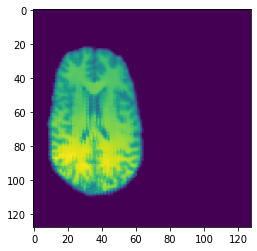

In [ ]:
plt.imshow(warped_img_np[:, 81, :])

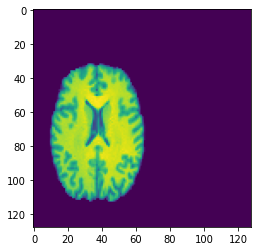

In [ ]:
plt.imshow(mynb_np1[0, :, 77, :])

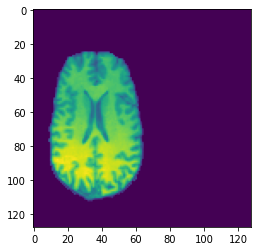

In [ ]:
plt.imshow(mynb_np2[0, :, 83, :])

# Miscellaneous

=========== Below are methods for testing outside function =======

In [ ]:
dim_prod = 128*128*128
num_bins = 10
bin_centers = np.linspace(0, 0.7, num_bins*2+1)[1::2]
sigma = np.mean(np.diff(bin_centers)) * 0.5
preterm = torch.tensor(1 / (2 * np.square(sigma)))
nb_voxels = torch.tensor([dim_prod], dtype=torch.float32)
print(bin_centers)
print(sigma)
print(preterm)
print(nb_voxels)

[0.035 0.105 0.175 0.245 0.315 0.385 0.455 0.525 0.595 0.665]
0.034999999999999996
tensor(408.1633, dtype=torch.float64)
tensor([2097152.])


In [ ]:
y_true = torch.ones(size= (1, 1, 128, 128, 128) )
y_pred = torch.ones(size = (1, 1, 128, 128, 128) )

In [ ]:
y_true = torch.randn(size= (1, 1, 128, 128) )
y_pred = torch.randn(size = (1, 1, 128, 128) )

In [ ]:
print(mutual_information(y_true, y_pred, sigma, preterm, bin_centers, nb_voxels, dim_prod = 128*128*128))

tensor([[[3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         [3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         [3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         ...,
         [3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         [3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         [3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07]]], dtype=torch.float64)
tensor([[[3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         [3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         [3.1618e-152, 3.7982e-129, 8.3570e-108,  ...,  3.7735e-27,
           3.1343e-16,  4.7684e-07],
         ...,
    

In [ ]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score

x1 = y_pred.numpy()
x1 = x1[0, 0, :, :]
x1 = x1.flatten()
x2 = y_true.numpy()
x2 = x2[0, 0, :, :]
x2 = x2.flatten()

def calc_MI(x, y, bins):
    #c_xy = np.histogram2d(x, y, bins)[0]
    mi = normalized_mutual_info_score(x, y)
    return mi

print(calc_MI( np.random.randn((128*128)), np.zeros((128*128,), dtype=float) , bins=10))

0.0


In [ ]:
torch.prod( torch.tensor(y_true.shape[1:]) ).numpy()

array(2097152)

In [ ]:
y_true = torch.reshape(y_true, (y_true.shape[0], 2097152, 1) )
y_pred = torch.reshape(y_pred, (y_pred.shape[0], 2097152, 1) )

In [ ]:
y_true.shape

torch.Size([1, 2097152, 1])

[0.035 0.105 0.175 0.245 0.315 0.385 0.455 0.525 0.595 0.665]
0.034999999999999996
tensor(408.1633, dtype=torch.float64)
tensor([2097152.])


In [ ]:
vbc = torch.tensor(bin_centers)
vbc = vbc.unsqueeze(0)
vbc = vbc.unsqueeze(0)
vbc.shape

torch.Size([1, 1, 10])

In [ ]:
# compute image terms
I_a = torch.exp(- preterm * torch.square(y_true  - vbc))
I_a = I_a/torch.sum(I_a)

I_b = torch.exp(- preterm * torch.square(y_pred  - vbc))
I_b = I_b/torch.sum(I_b)


In [ ]:
print(I_a)
print(I_b)

tensor([[[ 6.5326e-27,  2.2695e-19,  1.4441e-13,  ...,  1.3191e-10,
           3.1688e-15,  1.3942e-21],
         [ 3.9932e-30,  6.0496e-22,  1.6787e-15,  ...,  2.4180e-09,
           2.5330e-13,  4.8598e-19],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 9.1021e-54,  7.9033e-42,  1.2569e-31,  ...,  1.1196e-06,
           6.7217e-07,  7.3913e-09],
         [ 4.3524e-94,  1.6180e-77,  1.1017e-62,  ...,  1.4118e-14,
           3.6289e-10,  1.7084e-07],
         [ 1.0280e-54,  1.6155e-68,  4.6499e-84,  ..., 8.0445e-188,
          8.7413e-214, 1.7397e-241]]], dtype=torch.float64)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [6.5815e-116, 2.8716e-136, 2.2947e-158,  ..., 6.5483e-295,
           0.0000e+00,  0.0000e+00],
         [ 1.8454e-91, 1.6689e-109, 2.7644e-129,  ..., 3.0181e-254,
          1.8873e-284, 2.1615e-316],
         ...,
    

In [ ]:
# compute probabilities
I_a_permute = I_a.permute(0,2,1)
pab = torch.matmul(I_a_permute, I_b)  # should be the right size now, nb_labels x nb_bins
pab = pab/nb_voxels
pa = torch.mean(I_a, 1, keepdims=True)
pb = torch.mean(I_b, 1, keepdims=True)

In [ ]:
pa

tensor([[[5.1771e-08, 5.1641e-08, 5.0861e-08, 4.9979e-08, 4.8892e-08,
          4.7770e-08, 4.6599e-08, 4.5089e-08, 4.3151e-08, 4.1084e-08]]],
       dtype=torch.float64)

In [ ]:
pab

tensor([[[2.6876e-15, 2.6803e-15, 2.6424e-15, 2.6405e-15, 2.5752e-15,
          2.5397e-15, 2.4038e-15, 2.3070e-15, 2.1633e-15, 2.1026e-15],
         [2.6947e-15, 2.6716e-15, 2.6296e-15, 2.6169e-15, 2.5839e-15,
          2.5161e-15, 2.4354e-15, 2.2867e-15, 2.2095e-15, 2.1056e-15],
         [2.6844e-15, 2.6281e-15, 2.5919e-15, 2.6356e-15, 2.5634e-15,
          2.4295e-15, 2.3328e-15, 2.2204e-15, 2.1457e-15, 2.1021e-15],
         [2.5850e-15, 2.5322e-15, 2.4980e-15, 2.4965e-15, 2.4497e-15,
          2.3960e-15, 2.3350e-15, 2.2229e-15, 2.1098e-15, 2.0467e-15],
         [2.5047e-15, 2.4479e-15, 2.4660e-15, 2.4311e-15, 2.3562e-15,
          2.3147e-15, 2.2752e-15, 2.1814e-15, 2.1088e-15, 1.9809e-15],
         [2.4961e-15, 2.4172e-15, 2.4388e-15, 2.3598e-15, 2.2992e-15,
          2.3243e-15, 2.1958e-15, 2.1224e-15, 2.0956e-15, 1.9410e-15],
         [2.3780e-15, 2.3283e-15, 2.3683e-15, 2.3706e-15, 2.2520e-15,
          2.2319e-15, 2.1742e-15, 2.0618e-15, 1.9718e-15, 1.8966e-15],
         [2.3

In [ ]:
papb = torch.matmul(pa.permute(0,2,1), pb) + torch.finfo(torch.float32).eps
papb

tensor([[[1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07,
          1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07],
         [1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07,
          1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07],
         [1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07,
          1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07],
         [1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07,
          1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07],
         [1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07,
          1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07],
         [1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07,
          1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07],
         [1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07,
          1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07, 1.1921e-07],
         [1.1

In [ ]:
torch.finfo(torch.float32).eps

1.1920928955078125e-07

In [ ]:
mi = torch.sum(torch.sum(pab * torch.log(pab/papb + torch.finfo(torch.float32).eps), 1), 1)

In [ ]:
mi

tensor([-3.5838e-12], dtype=torch.float64)